# Image Segmentation

In [ ]:
#Run once per session
!pip install fastai2 -q

What is segmentation?
> セグメンテーションとは何ですか？

* Pixel-wise classes
* Used for fine-grained image segmenting
> * ピクセル単位のクラス
> * きめの細かい画像分割に使用

![](https://www.researchgate.net/profile/Anna_Boers/publication/235885350/figure/fig2/AS:299772243136518@1448482680597/Example-of-incorrect-automated-segmentation-due-to-hemorrhage-and-erroneous-midline.png)
[URL](https://www.researchgate.net/profile/Anna_Boers/publication/235885350/figure/fig2/AS:299772243136518@1448482680597/Example-of-incorrect-automated-segmentation-due-to-hemorrhage-and-erroneous-midline.png)

![](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/11/26/semantic-segmentation-1.jpg)
[URL](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/11/26/semantic-segmentation-1.jpg)

# Libraries

In [ ]:
from fastai2.vision.all import *

# Dataset

Todays dataset will be `CAMVID`, which is a segmentation based problem from cameras on cars to segment various areas of the road
> 今日のデータセットは`CAMVID`になります。これは、車のカメラからのセグメンテーションベースの問題であり、道路のさまざまな領域をセグメント化します

In [ ]:
path = untar_data(URLs.CAMVID)

Our validation set is inside a text document called `valid.txt` and split by new lines. Let's read it in:
> 検証セットは`valid.txt`というテキストドキュメント内にあり、新しい行で分割されています。 それを読みましょう：

In [ ]:
valid_fnames = (path/'valid.txt').read().split('\n')

In [ ]:
valid_fnames[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

Let's look at an image and see how everything aligns up
> 画像を見て、すべてがどのように揃っているか見てみましょう

In [ ]:
path_im = path/'images'
path_lbl = path/'labels'

First we need our filenames
> 最初にファイル名が必要です

In [ ]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

And now let's work with one of them
> そして、それらの1つと一緒に作業しましょう

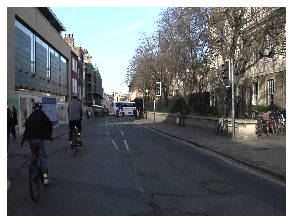

In [ ]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

Now let's grab our y's. They live in the `labels` folder and are denoted by a `_P`
> 次に、yを取得します。 それらは `labels`フォルダーにあり、`_P`で示されます

In [ ]:
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

The stem and suffix grab everything before and after the period respectively.
> 語幹と接尾辞は、それぞれ期間の前後にすべてを取得します。

Our masks are of type `PILMask` and we will make our gradient percentage (alpha) equal to 1 as we are not overlaying this on anything yet
> マスクのタイプは`PILMask`で、グラデーションパーセンテージ（アルファ）はまだ何もオーバーレイしていないため、1に等しくします。

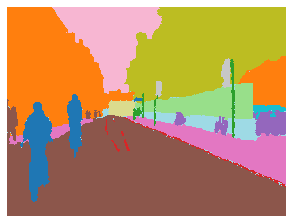

In [ ]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

Now if we look at what our mask actually is, we can see it's a giant array of pixels:
> マスクが実際に何であるかを見ると、それはピクセルの巨大な配列であることがわかります。

In [ ]:
tensor(msk)

tensor([[ 4,  4,  4,  ..., 26, 26, 26],
        [ 4,  4,  4,  ..., 26, 26, 26],
        [ 4,  4,  4,  ..., 26, 26, 26],
        ...,
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17]], dtype=torch.uint8)

Where each one represents a class that we can find in `codes.txt`. Let's make a vocabulary with it
> それぞれが `codes.txt`で見つけることができるクラスを表します。 それでボキャブラリーを作ろう

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

We need a split function that will split from our list of valid filenames we grabbed earlier. Let's try making our own.
> 以前に取得した検証ファイル名のリストから分割する分割関数が必要です。 自分で作ってみましょう。

In [ ]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    "`mask`の値に応じて`items`を分割する."
    valid = Path(fname).read().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

This takes in our filenames, and checks for all of our filenames in all of our items in our validation filenames
> これはファイル名を取り込み、検証ファイル名のすべてのアイテムですべてのファイル名をチェックします

In [ ]:
valid = Path(path/'valid.txt').read().split('\n') 
print(len(valid))
print(valid[:5])
print(fnames[0].name in valid)

102
['0016E5_07959.png', '0016E5_07961.png', '0016E5_07963.png', '0016E5_07965.png', '0016E5_07967.png']
False


In [ ]:
fs = FileSplitter(path/'valid.txt')
fs(fnames)

((#600) [0,1,2,3,4,5,6,7,9,11...], (#101) [8,10,18,20,32,33,44,45,52,55...])

# Transfer Learning between DataSets
> データセット間の学習の転送

Jeremy popularized the idea of image resizing:
* Train on smaller sized images
* Eventually get larger and larger
* Transfer Learning loop

> ジェレミーはイメージのサイズ変更のアイデアを広めました：
> * 小さいサイズの画像でトレーニングする
> * 最終的にはどんどん大きくなる
> * 転移学習ループ

This first round we will train at half the image size
> この最初のラウンドでは、画像サイズの半分でトレーニングします

In [ ]:
sz = msk.shape; sz

(720, 960)

In [ ]:
half = tuple(int(x/2) for x in sz); half

(360, 480)

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = camvid.dataloaders(path/'images', bs=8)

Let's look at a batch, and look at all the classes between codes 1 and 30 (ignoring `Animal` and `Wall`)
> バッチを見て、コード1と30の間のすべてのクラスを見てみましょう（`Animal`と`Wall`は無視します）

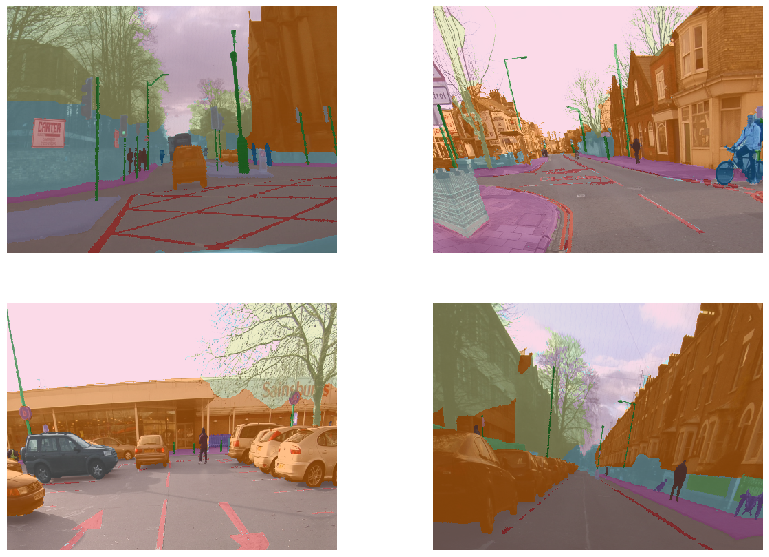

In [ ]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

Lastly let's make our vocabulary a part of our `DataLoaders`, as our loss function needs to deal with the `Void` label
> 最後に、損失関数が `Void`ラベルを処理する必要があるので、語彙を`DataLoaders`の一部にします

In [ ]:
dls.vocab = codes

Now we need a methodology for grabbing that particular code from our output of numbers. Let's make everything into a dictionary
> 次に、数値の出力からその特定のコードを取得する方法が必要です。 すべてを辞書にしましょう

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}

In [ ]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

Awesome! Let's make an accuracy function
> 驚くばかり！ 精度関数を作ろう

In [ ]:
void_code = name2id['Void']

For segmentation, we want to squeeze all the outputted values to have it as a matrix of digits for our segmentation mask. From there, we want to match their argmax to the target's mask for each pixel and take the average
> セグメンテーションでは、出力されたすべての値を絞り込んで、セグメンテーションマスクの数字の行列として使用します。 そこから、それらのargmaxを各ピクセルのターゲットのマスクに一致させ、平均を取ります。

In [ ]:
def acc_camvid(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

# Model

## U-Net

![](http://deeplearning.net/tutorial/_images/unet.jpg)

U-Net allows us to look at pixel-wise representations of our images through sizing it down and then blowing it bck up into a high resolution image. The first part we call an "encoder" and the second a "decoder"
> U-Netを使用すると、画像のサイズを小さくしてから、高解像度の画像に拡大することで、画像のピクセル単位の表現を確認できます。 最初の部分は「エンコーダ」と呼ばれ、2番目の部分は「デコーダ」と呼ばれます

On the image, the authors of the UNET paper describe the arrows as "denotions of different operations"
> 画像では、UNET論文の著者が矢印を「さまざまな操作の名称」として説明しています

We have a special `unet_learner`. Something new is we can pass in a configuration(`unet_config`) where we can declare a few things!

* Blur/blur final: avoid checkerboard artifacts
* Self attention: A self-attention layer
* y_range: Last activations go through a sigmoid for rescaling
* Last cross - Cross-connection with the direct model input
* Bottle - Bottlenck or not on that cross
* Activation function
* Norm type

> 特別な `unet_learner`があります。 新しいものは、いくつかのことを宣言できるconfiguration（ `unet_config`）に渡すことができることです！
> * ぼかし/ぼかし最終：チェッカーボードアーティファクトを回避
> * セルフアテンション：セフルアテンションレイヤー
> * y_range：最後のアクティベーションは再スケーリングのためにシグモイドを通過します
> * 最終交差 - 直接モデル入力との相互接続
> * ボトル - そのクロスにボトルネックかどうか
> * アクティベーション機能
> * ノルムタイプ

Let's make a `unet_learner` that uses some of the new state of the art techniques. Specifically:

* Self-attention layers: `self_attention = True`
* Mish activation function: `act_cls = Mish`

> いくつかの新しい最先端のテクニックを使用する `unet_learner`を作ってみましょう。 具体的には：
> * セフルアテンションレイヤー： `self_attention = True`
> * Mishアクティベーション関数： `act_cls = Mish`

In [ ]:
config = unet_config(self_attention=True, act_cls=Mish)

Along with this we will use the `Ranger` as optimizer function.
> これに加えて、オプティマイザー関数として`Ranger`を使用します。

In [ ]:
opt = ranger

In [ ]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, config=config,
                     opt_func=opt)

In [ ]:
learn.summary()

DynamicUnet (Input shape: ['8 x 3 x 360 x 480'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 180 x 240   9,408      False     
________________________________________________________________
BatchNorm2d          8 x 64 x 180 x 240   128        True      
________________________________________________________________
ReLU                 8 x 64 x 180 x 240   0          False     
________________________________________________________________
MaxPool2d            8 x 64 x 90 x 120    0          False     
________________________________________________________________
Conv2d               8 x 64 x 90 x 120    36,864     False     
________________________________________________________________
BatchNorm2d          8 x 64 x 90 x 120    128        True      
________________________________________________________________
ReLU                 8 x 64 x 90 x 120    0          False     
_________________________________________________

If we do a `learn.summary` we can see this blow-up trend, and see that our model came in frozen. Let's find a learning rate
> `learn.summary`を実行すると、この爆発的な傾向がわかり、モデルがフリーズしたことがわかります。 学習率を調べましょう

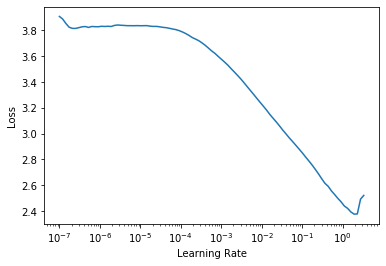

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-3

With our new optimizer, we will also want to use a different fit function, called `fit_flat_cos`
> 新しいオプティマイザーでは、 `fit_flat_cos`と呼ばれる別のフィット関数も使用する必要があります

In [ ]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,2.267863,1.742724,0.827059,01:12
1,1.821520,1.487319,0.858477,00:59
2,1.588776,1.349779,0.865436,00:59
3,1.430715,1.215538,0.886508,00:59
4,1.324019,1.124806,0.902292,00:59
5,1.232799,1.035299,0.903780,00:59
6,1.133886,0.990665,0.904250,00:59
7,1.059976,0.914800,0.911261,00:59
8,0.980094,0.883291,0.914787,00:59
9,0.920574,0.861305,0.915084,00:59


In [ ]:
learn.save('stage-1')
learn.load('stage-1');

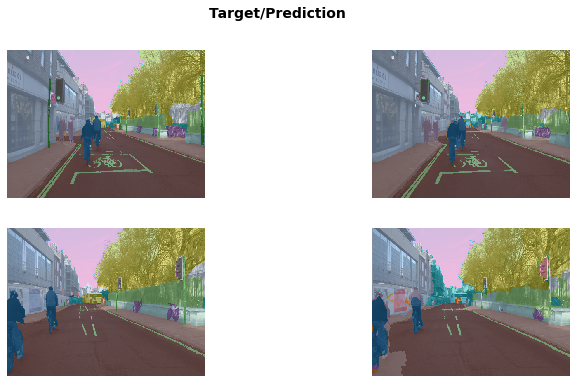

In [ ]:
learn.show_results(max_n=4, figsize=(12,6))

Let's unfreeze the model and decrease our learning rate by 4 (Rule of thumb)
> モデルのフリーズを解除して、学習率を4減らします（経験則）

In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
lr, lrs

(0.001, slice(2.5e-06, 0.00025, None))

In [ ]:
learn.unfreeze()

And train for a bit more
> そしてもう少し訓練します

In [ ]:
learn.fit_flat_cos(12, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.904472,0.864132,0.914719,01:01
1,0.893953,0.861930,0.915803,01:01
2,0.870641,0.839532,0.915104,01:00
3,0.857703,0.844047,0.912143,01:00
4,0.835774,0.817610,0.914030,01:00
5,0.818883,0.815786,0.915836,01:01
6,0.790792,0.797801,0.914842,01:01
7,0.782354,0.782085,0.916641,01:01
8,0.764274,0.766298,0.917362,01:00
9,0.747887,0.769105,0.917114,01:01


Now let's save that model away
> 次に、そのモデルを保存してみましょう

In [ ]:
learn.save('model_1')

And look at a few results
> そして、いくつかの結果を見てください

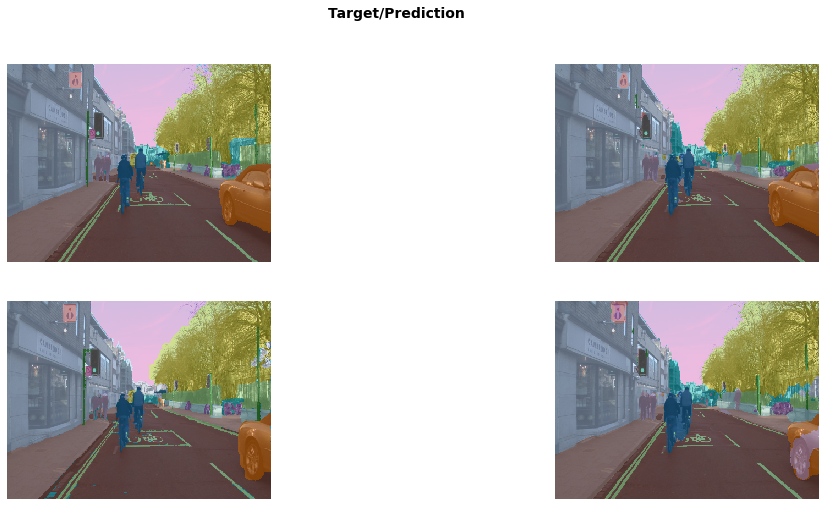

In [ ]:
learn.show_results(max_n=4, figsize=(18,8))

# Inference
> 推論

Let's take a look at how to do inference with `test_dl`
> `test_dl`で推論を行う方法を見てみましょう

In [ ]:
dl = learn.dls.test_dl(fnames[:5])

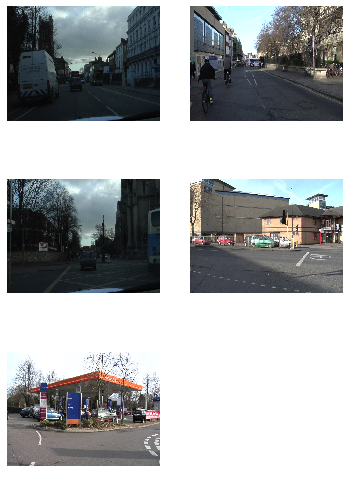

In [ ]:
dl.show_batch()

Let's do the first five pictures
> 最初の5枚の写真をしましょう

In [ ]:
preds = learn.get_preds(dl=dl)

In [ ]:
preds[0].shape

torch.Size([5, 32, 360, 480])

Alright so we have a 5x32x360x480
> よし、5x32x360x480

In [ ]:
len(codes)

32

What does this mean? We had five images, so each one is one of our five images in our batch. Let's look at the first
> これは何を意味するのでしょうか？ 5つの画像があるため、各画像はバッチ内の5つの画像の1つです。 最初を見てみましょう

In [ ]:
pred_1 = preds[0][0]

In [ ]:
pred_1.shape

torch.Size([32, 360, 480])

Now let's take the argmax of our values
> 次に、値のargmaxを取得します

In [ ]:
pred_arx = pred_1.argmax(dim=0)

And look at it
> そしてそれを見てください

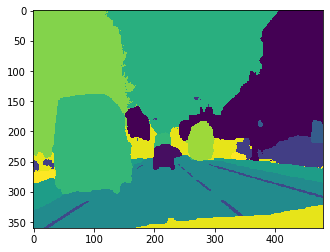

In [ ]:
plt.imshow(pred_arx)

What do we do from here? We need to save it away. We can do this one of two ways, as a numpy array to image, and as a tensor (to say use later rawly)
> ここから何をしますか？ 保存する必要があります。 これは、イメージへの派手な配列として、およびテンソルとして（後で生で使用すると言う）の2つの方法のいずれかで実行できます。

In [ ]:
pred_arx = pred_arx.numpy()

In [ ]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [ ]:
im = Image.fromarray(rescaled)

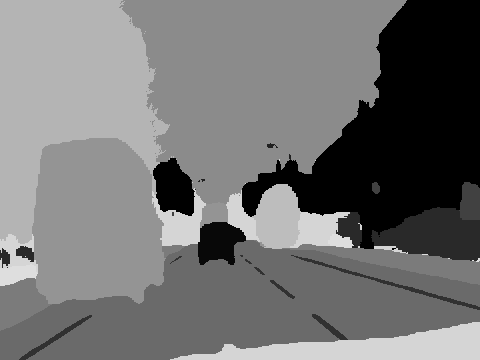

In [ ]:
im

In [ ]:
im.save('test.png')

Let's make a function to do so for our files
> ファイルのためにそうする関数を作ってみましょう

In [ ]:
for i, pred in enumerate(preds[0]):
    pred_arg = pred.argmax(dim=0).numpy()
    rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save(f'Image_{i}.png')

Now let's save away the raw:
> 今、生データを保存しましょう：

In [ ]:
torch.save(preds[0][0], 'Image_1.pt')

In [ ]:
pred_1 = torch.load('Image_1.pt')

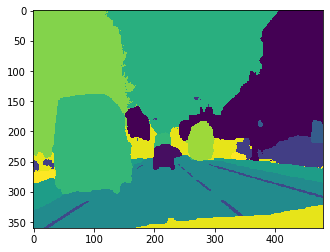

In [ ]:
plt.imshow(pred_1.argmax(dim=0))

# Full Size (Homework)

Now let's go full sized. Restart your instance to re-free your memory
> さあ、フルサイズにしましょう。 インスタンスを再起動してメモリを解放します

In [ ]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [ ]:
path = untar_data(URLs.CAMVID)
valid_fnames = (path/'valid.txt').read().split('\n')
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

def ListSplitter(items):
    def _inner(it):
        val_mask = tensor([o.name in items for o in it])
        return [~val_mask, val_mask]
    return _inner

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

And re-make our dataloaders. But this time we want our size to be the full size
> そして、データローダーを作り直します。 今回はフルサイズにしたい

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

We'll also want to lower our batch size to not run out of memory
> また、メモリが不足しないように、バッチサイズを小さくしたいと思います。

In [ ]:
dls = camvid.dataloaders(path/"images", bs=1)

Let's assign our vocab, make our learner, and load our weights
> 語彙を割り当て、learnerにして、ウエイトをロードしましょう

In [ ]:
config = unet_config(self_attention=True, act_cls=Mish)
opt = ranger

In [ ]:
dls.vocab = codes
learn = unet_learner(dls, resnet34, metrics=acc_camvid, config=config,
                     opt_func=opt)
learn.load('model_1');

And now let's find our learning rate and train!
> そして今、私たちの学習率を見つけて訓練しましょう！

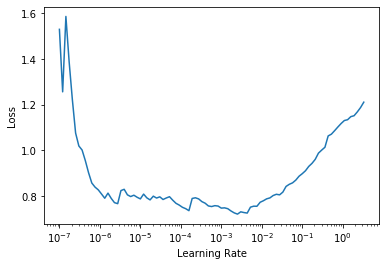

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-3

In [ ]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.506793,0.342499,0.926143,05:15
1,0.430471,0.331063,0.924518,05:14
2,0.349916,0.330467,0.915646,05:14
3,0.330413,0.291114,0.926524,05:13
4,0.307470,0.273733,0.928941,05:13
5,0.281810,0.278765,0.926421,05:12
6,0.250463,0.288746,0.923950,05:12
7,0.248945,0.284137,0.923201,05:11
8,0.214759,0.256868,0.931487,05:10
9,0.188897,0.267987,0.928474,05:10


In [ ]:
learn.save('full_1')

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10); lrs

slice(1e-06, 0.0001, None)

In [ ]:
learn.fit_flat_cos(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.187095,0.266967,0.926938,05:20
1,0.186410,0.262047,0.928341,05:20
2,0.190994,0.282032,0.922368,05:19
3,0.186702,0.262346,0.929233,05:19
4,0.179937,0.270361,0.925767,05:19
5,0.176367,0.270718,0.926208,05:19
6,0.176295,0.259349,0.928089,05:19
7,0.171654,0.260007,0.928189,05:19
8,0.170364,0.261180,0.928160,05:19
9,0.160006,0.253466,0.929910,05:19


In [ ]:
learn.save('full_2')

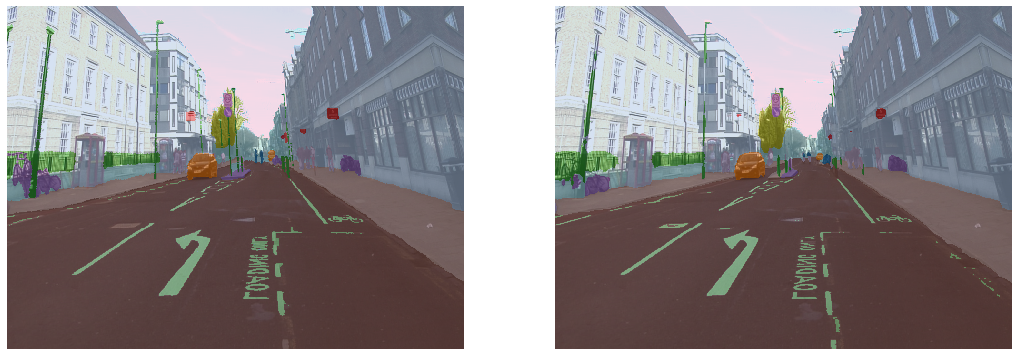

In [ ]:
learn.show_results(max_n=4, figsize=(18,8))

# Weighted Loss Functions

We can use weighted loss functions to help with class imbalancing. We need to do this because simply oversampling won't quite work here! So, how do we do it? `fastai2`'s `CrossEntropyLossFlat` is just a wrapper around `PyTorch`'s `CrossEntropyLoss`, so we can pass in a `weight` parameter (even if it doesn't show up in our autocompletion!) 
> 重み付き損失関数を使用して、クラスの不均衡を支援できます。 単純にオーバーサンプリングはここではうまく機能しないため、これを行う必要があります！ それで、どうやってそれを行うのですか？ `fastai2`の` CrossEntropyLossFlat`は、 `PyTorch`の`CrossEntropyLoss`のラッパーにすぎないため、（オートコンプリートに表示されない場合でも） `weight`パラメーターを渡すことができます！

In [ ]:
class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

But what should this weight be? It needs to be a 1x`n` tensor, where `n` is the number of classes in your dataset. We'll use a quick example, where all but the last class has a weight of 90% and the last class has a weight of 110%
> しかし、このウエイトはどうあるべきでしょうか？ 1x`n`テンソルである必要があります。ここで、 `n`はデータセット内のクラスの数です。 最後のクラス以外のすべてのウェイトが90％で、最後のクラスのウェイトが110％である簡単な例を使用します

Also, as we are training on the GPU, we need the tensor to be so as well:
> また、GPUでトレーニングしているため、テンソルもそうである必要があります。

In [ ]:
weights = torch.tensor([[0.9]*31 + [1.1]]).cuda()

In [ ]:
weights

tensor([[0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 1.1000]], device='cuda:0')

Now we can pass this into `CrossEntropyLossFlat`
> これを `CrossEntropyLossFlat`に渡すことができます

* **Note**: as this is segmentation, we need to make the axis to 1
> * **注**：これはセグメンテーションであるため、軸を1にする必要があります

In [ ]:
learn.loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

(or to pass it into `cnn_learner`)

In [ ]:
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

In [ ]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, loss_func=loss_func)